In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [3]:
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import gc
import matplotlib.pyplot as plt
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader

In [4]:
train_path = './data/Covid-19 Image Dataset/train'
test_path = './data/Covid-19 Image Dataset/test'
base_path = './data'
classic_folder = 'Coivd-19_Classic'
synthetic_folder = 'Coivd-19_Synthetic'

In [5]:
labels = os.listdir(train_path)
print(labels)
no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)

['Covid', 'Normal', 'Viral Pneumonia']


In [6]:
def load_random_imgs_from_folder(folder, label):
    plt.figure(figsize=(15, 15))
    for i in range(3):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img_bgr = cv2.imread(image_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, 3, i+1)
        ax.title.set_text(label)
        plt.xlabel(f'Name: {file} , "Size: {img.shape}"')
        plt.imshow(img, norm=no_norm)

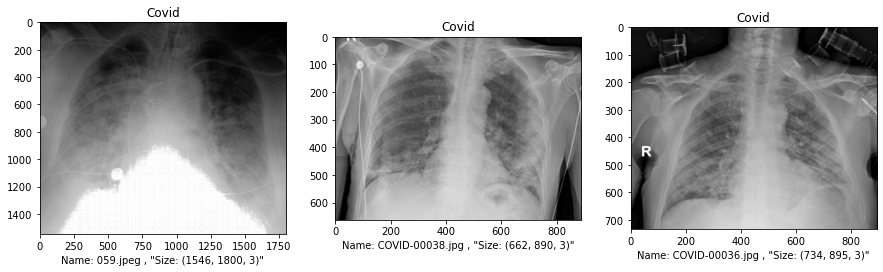

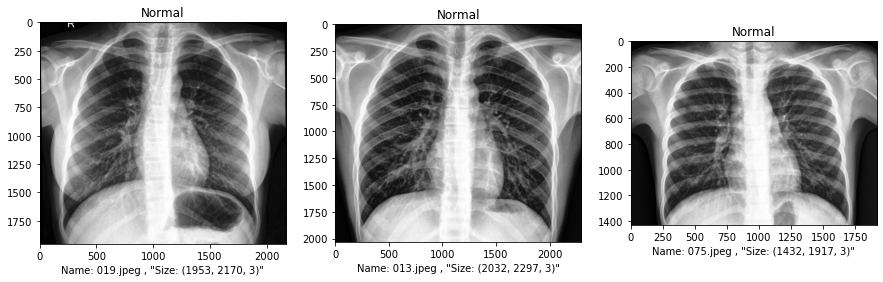

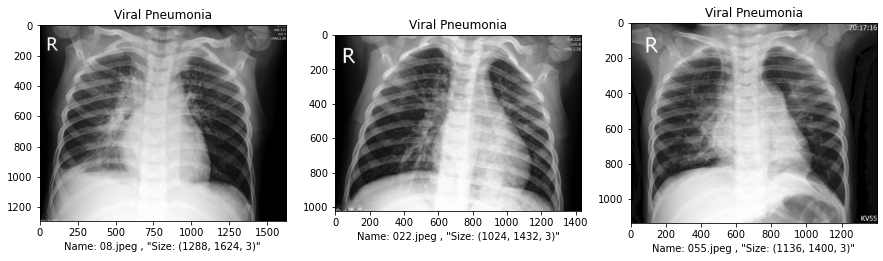

In [7]:
for label in labels:
    load_random_imgs_from_folder(f"{train_path}/{label}",label)

In [8]:
for func in [lambda: os.mkdir(os.path.join(base_path, classic_folder)),
             lambda: os.mkdir(os.path.join(base_path, synthetic_folder)),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, classic_folder), 'test')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'train')),
             lambda: os.mkdir(os.path.join(os.path.join(base_path, synthetic_folder), 'test'))
            ]:
    try:
        func()
    except Exception as error:
        print(error)
        continue

[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic\\train'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Classic\\test'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic\\train'
[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic\\test'


In [9]:
def func_2():
    for label in labels:
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'test'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, synthetic_folder), 'train'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'test'), label))
        os.mkdir(os.path.join(os.path.join(os.path.join(base_path, classic_folder), 'train'), label))
try:
    func_2()
except Exception as error:
    print(error)

[WinError 183] 当文件已存在时，无法创建该文件。: './data\\Coivd-19_Synthetic\\test\\Covid'


In [10]:
Config = {
    "ROT": 4,
    "H_FL": 2,
    "PER": 2,
    "AFF_S": 4,
    "AFF_T": 4,
    "COL": 4,
    "PAD": 2
}
img_size = 1024
a_degrees = 18
a_distortion_scale = 0.3
a_scale = (0.7, 1.3)
a_translate = (0.2, 0.2)
a_jitter = [0.5, 0.5, 0.5, 0.5]
a_padding_ratio = 0.1

In [11]:
def show_classic_aug(image_path):
    print("image_path ->", image_path)
    image = Image.open(image_path)
#     image = transforms.Resize((img_size, img_size), interpolation=2)(image)
#     image = transforms.ToTensor()(image)
    img_aug, names = [], []
    img_aug.append(image)
    names.append("Original-Image")
    img_aug.append(transforms.RandomRotation(degrees=(-a_degrees, a_degrees))(image))
    names.append("RandomRotation")
    img_aug.append(transforms.RandomHorizontalFlip(p=1)(image))
    names.append("RandomHorizontalFlip")
    img_aug.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5)(image))
    names.append("RandomPerspective")
    img_aug.append(transforms.RandomAffine(degrees=0, scale=a_scale)(image))
    names.append("RandomAffine-Scale")
    img_aug.append(transforms.RandomAffine(degrees=0, translate=a_translate)(image))
    names.append("RandomAffine-Translate")
    img_aug.append(transforms.ColorJitter(brightness=a_jitter[0], 
                                          contrast=a_jitter[1], 
                                          saturation=a_jitter[2], 
                                          hue=a_jitter[3])(image))
    names.append("ColorJitter")
    img_aug.append(transforms.Pad(padding=round(a_padding_ratio * img_size),
                                  fill=0,
                                  padding_mode='symmetric')(image))
    names.append("Pad")
    plt.figure(figsize=(20, 10))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_aug[i], norm=no_norm)
        plt.title(names[i])
    plt.show()

image_path -> ./data/Covid-19 Image Dataset/train/Covid/080.jpg


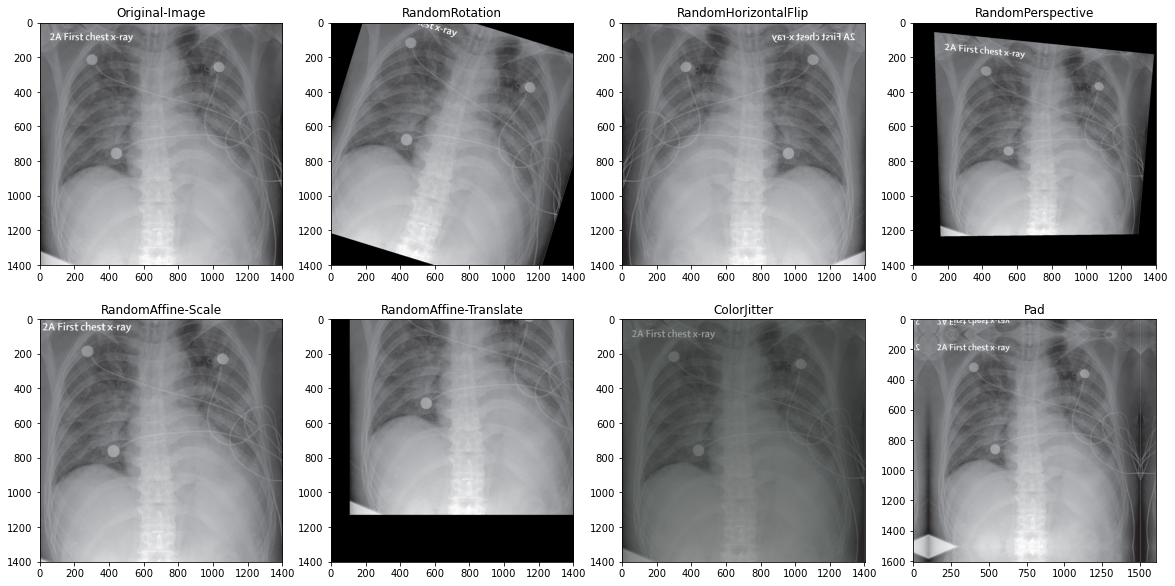

In [12]:
random_label = random.choice(os.listdir(train_path))
show_classic_aug(train_path + "/" + random_label + "/" + random.choice(os.listdir(train_path + "/" + random_label)))

In [13]:
def build_transforms():
    transform_list = []
    for i in range(Config["ROT"]):
        transform_list.append(transforms.RandomApply([transforms.RandomRotation(degrees=(-a_degrees, a_degrees))], p=0.5))
    for i in range(Config["H_FL"]):
        transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
    for i in range(Config["PER"]):
        transform_list.append(transforms.RandomPerspective(distortion_scale=a_distortion_scale, p=0.5))
    for i in range(Config["AFF_S"]):
        transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,
                                                                              scale=a_scale)], p=0.5))
    for i in range(Config["AFF_T"]):
        transform_list.append(transforms.RandomApply([transforms.RandomAffine(degrees=0,
                                                                              translate=a_translate)], p=0.5))
    for i in range(Config["COL"]):
        transform_list.append(transforms.RandomApply([transforms.ColorJitter(brightness=a_jitter[0], 
                                                                             contrast=a_jitter[1], 
                                                                             saturation=a_jitter[2], 
                                                                             hue=a_jitter[3])], p=0.5))
    for i in range(Config["PAD"]):
        transform_list.append(transforms.RandomApply([transforms.Pad(padding=round(a_padding_ratio * img_size),
                                                                     fill=0,
                                                                     padding_mode='symmetric')], p=0.5))
    transform_list.append(transforms.Resize((img_size, img_size),interpolation=2))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    test_transform = transforms.Compose([transforms.Resize((img_size, img_size),interpolation=2),
                                         transforms.ToTensor(),
                                        ])
    return transform, test_transform

In [14]:
def generator_data(transform, test_transform):
    train_dataset = ImageFolder(root=train_path, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_dataset = ImageFolder(root=test_path, transform=test_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    original_train_dataset = ImageFolder(root=train_path, transform=test_transform)
    original_train_dataloader = DataLoader(original_train_dataset, batch_size=1, shuffle=True)
    dataset_list = [train_dataset, test_dataset, original_train_dataset]
    dataloader_list = [train_dataloader, test_dataloader, original_train_dataloader]
    return dataset_list, dataloader_list

In [15]:
transform, test_transform = build_transforms()
dataset_list, dataloader_list = generator_data(transform, test_transform)

D:\Miniconda3\envs\torch_1-11\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
